In [1]:
import pickle
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Import modules from the backtester package
from weight_generator import BettingAgainstBetaWeightsGenerator
from backtest_engine import EquityBacktestEngine
from metrics import ExtendedMetrics
import warnings
warnings.filterwarnings("ignore")

# first, run python cache_sp500_data.py to prevent caching all universe every run, then run this script
with open('sp500_data.pkl', 'rb') as f:
    sp500_data = pickle.load(f)

if 'SPY' not in sp500_data:
    sample_ticker = list(sp500_data.keys())[0]
    dates = sp500_data[sample_ticker].index
    start_date = dates.min().strftime('%Y-%m-%d')
    end_date = dates.max().strftime('%Y-%m-%d')
    spy_df = yf.download("SPY", start=start_date, end=end_date, auto_adjust=False)
    # keep only the needed columns to mimic the structure in the cache
    spy_df = spy_df[['Adj Close', 'Volume']].copy()
    sp500_data['SPY'] = spy_df

# exclude SPY since that is our benchmark
stock_tickers = [ticker for ticker in sp500_data.keys() if ticker != 'SPY']
prices_dict = {}
for ticker in stock_tickers:
    df = sp500_data[ticker]
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    prices_dict[ticker] = df['Adj Close']

price_df = pd.DataFrame(prices_dict).dropna(how='all')
price_df = price_df.sort_index()
bab_generator = BettingAgainstBetaWeightsGenerator(lookback_period=60, rebalance_frequency='ME')
weights_df = bab_generator.generate_weights(sp500_data) # New
print(f"Generated weights DataFrame with shape: {weights_df.shape}")

[*********************100%***********************]  1 of 1 completed


Rebalancing weights on 2010-04-30 00:00:00:
  Long: 0.41, Short: 0.09
  Long beta: 0.17, Short beta: -0.17, Net beta: 0.0000
Rebalancing weights on 2010-06-30 00:00:00:
  Long: 0.39, Short: 0.11
  Long beta: 0.19, Short beta: -0.19, Net beta: 0.0000
Rebalancing weights on 2010-08-31 00:00:00:
  Long: 0.40, Short: 0.10
  Long beta: 0.19, Short beta: -0.19, Net beta: 0.0000
Rebalancing weights on 2010-09-30 00:00:00:
  Long: 0.41, Short: 0.09
  Long beta: 0.18, Short beta: -0.18, Net beta: 0.0000
Rebalancing weights on 2010-11-30 00:00:00:
  Long: 0.42, Short: 0.08
  Long beta: 0.15, Short beta: -0.15, Net beta: -0.0000
Rebalancing weights on 2010-12-31 00:00:00:
  Long: 0.42, Short: 0.08
  Long beta: 0.14, Short beta: -0.14, Net beta: 0.0000
Rebalancing weights on 2011-01-31 00:00:00:
  Long: 0.43, Short: 0.07
  Long beta: 0.13, Short beta: -0.13, Net beta: -0.0000
Rebalancing weights on 2011-02-28 00:00:00:
  Long: 0.45, Short: 0.05
  Long beta: 0.12, Short beta: -0.12, Net beta: 0.000

In [ ]:
initial_cash = 100_000
engine = EquityBacktestEngine(initial_cash=initial_cash)
backtest_result = engine.run_backtest(weights_df, price_df)
portfolio_values_series = backtest_result['portfolio_values'] 

portfolio_returns = portfolio_values_series.pct_change().dropna()

spy_prices = sp500_data['SPY']['Adj Close']
spy_prices.index = pd.to_datetime(spy_prices.index)
spy_prices = spy_prices.sort_index()
spy_returns = spy_prices.pct_change().dropna()

Backtest complete. Final Portfolio Value: 174005.44



Performance Metrics:
Cumulative Return (%): 74.00544442053652
Annualized Return (%): 4.059756498954115
Annualized Volatility (%): 5.581543356123052
Sharpe Ratio: 0.63241060663288
Max Drawdown (%): -17.04792453141423
VaR 5% Daily (%): -0.4575472864642549
CVaR 5% Daily (%): -0.803829925856852


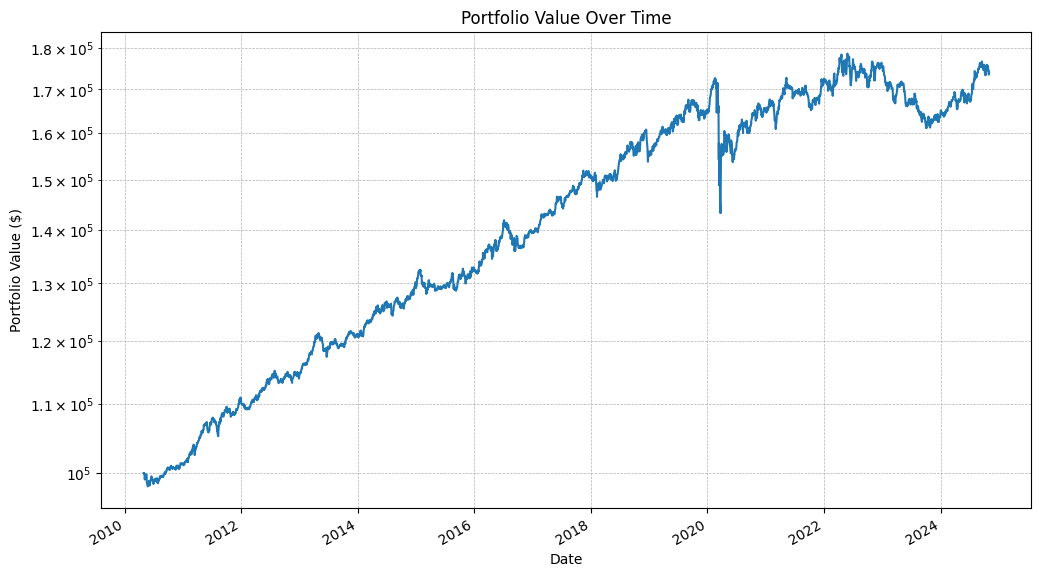

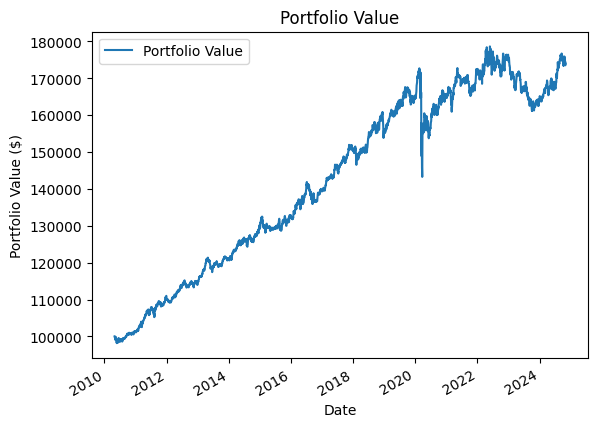

In [ ]:
metrics_calculator = ExtendedMetrics()
metrics = metrics_calculator.calculate(portfolio_values_series, 
                                      portfolio_returns,
                                      benchmark_returns=spy_returns)
print("\nPerformance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")
    
# plot returns
plt.title('Portfolio Value')
plt.xlabel('Date')
portfolio_values_series.plot(label='Portfolio Value')
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()